In [1]:
from tqdm import tqdm
from D3QNAgent import Agent
from kaggle_environments import evaluate, make, utils
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

env = make("connectx", debug=True)
env.render()

nstep_lookahead_agent = './fast_Nstep_lookahead_agent.py'
random_agent = 'random'
negamax_agent = 'negamax'

Loading environment football failed: No module named 'gfootball'


In [2]:
def live_plot(rewards):
    # if len(rewards) < 100:
    #     return
    
    avg_reward_100 = np.convolve(rewards, np.ones(100), mode='valid') / 100

    clear_output(wait=True)
    fig, ax1 = plt.subplots(dpi=120, figsize=(12.8, 7.2))
    ax1.plot(avg_reward_100, color='orange', linestyle='-')
    ax1.set_ylabel('reward')
    ax1.set_xlabel('episode')
    ax1.title.set_text('Agent Total Rewards with Moving Average 100 Episodes')

    plt.show()

    # print('episode', i, 
    #     # '\ttotal rewards %.1f' % tot_reward, 
    #     # '\taverage rewards %.3f' % avg_rewards[i], 
    #     # '\tresult ', reward, 
    #     # '\twin/loss ratio %.3f' % wl_ratio[i], 
    #     '\tepsilon %.3f' % eps)


In [3]:
def playalong_agent(obs, config):
    # define agent
    agent = Agent(config, input_shape=(None, 6, 7, 2), testing=True)
    try:

        agent.load_DQN_weights('./models/best-param-self-play.h5')

        # preprocessing of the state
        state = preprocess_board_state(obs)

        return agent.choose_action(state)
    
    except:
        state = obs.board
        mask = [True if state[idx] == 0 else False for idx in range(config.columns)]
        valid_action_space = np.where(mask)[0]
        action = np.random.choice(valid_action_space)
        return action.item()

In [4]:
def preprocess_board_state(observation):
    board = np.array(observation['board'], dtype=np.float32).reshape(6, 7)
    marker = observation.mark

    state = np.zeros((6, 7, 2), dtype=np.float32)
    
    if marker == 1:
        state[:, :, 0][board == 1] = 1
        state[:, :, 1][board == 2] = 1
        
    else:
        state[:, :, 0][board == 2] = 1
        state[:, :, 1][board == 1] = 1

    return state

In [5]:
agent = Agent(
    env.configuration, 
    lr=0.0005, 
    gamma=0.95, 
    batch_size=128,    #### REMEMBER TO CHANGE IT BACK ####
    epsilon=1,        #### REMEMBER TO CHANGE IT BACK ####
    eps_dec=0.99975,
    eps_min=0.02,
    buff_size=50_000,
    conv1_filts=16,
    d1_dims=128,
    d2_dims=128,
    replace_target_weight=20,
    input_shape=(None, 6, 7, 2),
)


In [6]:
rewards = []

In [ ]:
# transfer prior knowledge
# agent.load_DQN_weights('./models/cnn-nsl-5-0.0005-128-0.95-20.h5')

In [7]:
num_episodes = 1000
num_rounds = 20

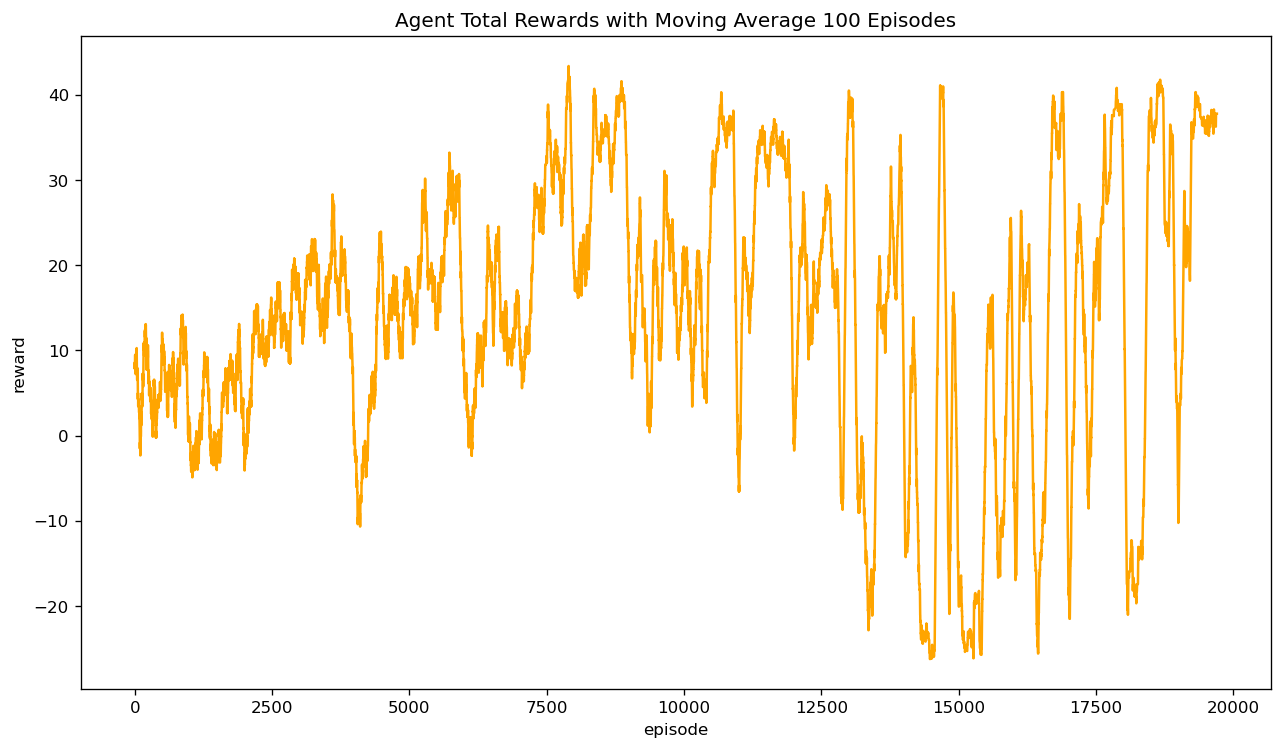

100%|██████████| 20/20 [6:09:32<00:00, 1108.64s/it]


In [8]:
for j in tqdm(range(num_rounds)):

    agent.reset_epsilon()

    if j % 1:
        # None means the agent being trained
        trainer = env.train([playalong_agent, None])
    else:
        trainer = env.train([None, playalong_agent])


    for i in tqdm(range(num_episodes)):
        done = False
        tot_reward = 0

        observation = trainer.reset()
        obs = preprocess_board_state(observation)
        
        # print(obs.reshape(6, 7))

        while not done:

            # choose the best action
            action = agent.choose_action(obs)
            
            # step the environment with action
            # store all returns
            observation_, reward, done, info = trainer.step(action)

            # reprocess the new raw state from the environment
            obs_ = preprocess_board_state(observation_)

            # calculate agent reward from environment response
            agent_reward = agent.get_agent_reward(reward, done)
            
            tot_reward += agent_reward
            
            # store this transition
            agent.update_replay_buffer((obs, action, agent_reward, obs_, done))
                
            # update the current obs with new obs
            obs = obs_
            
            agent.learn()
        
        agent.evolve()

        # store total rewards
        rewards.append(tot_reward)
        # store average rewards
        # avg_rewards.append(np.mean(rewards[-100:]))
        
        
        if i % 200 == 0:
            live_plot(rewards)
        

    # live_plot(avg_rewards, i, agent.epsilon)
    agent.save_DQN_weights('./models/best-param-self-play.h5')

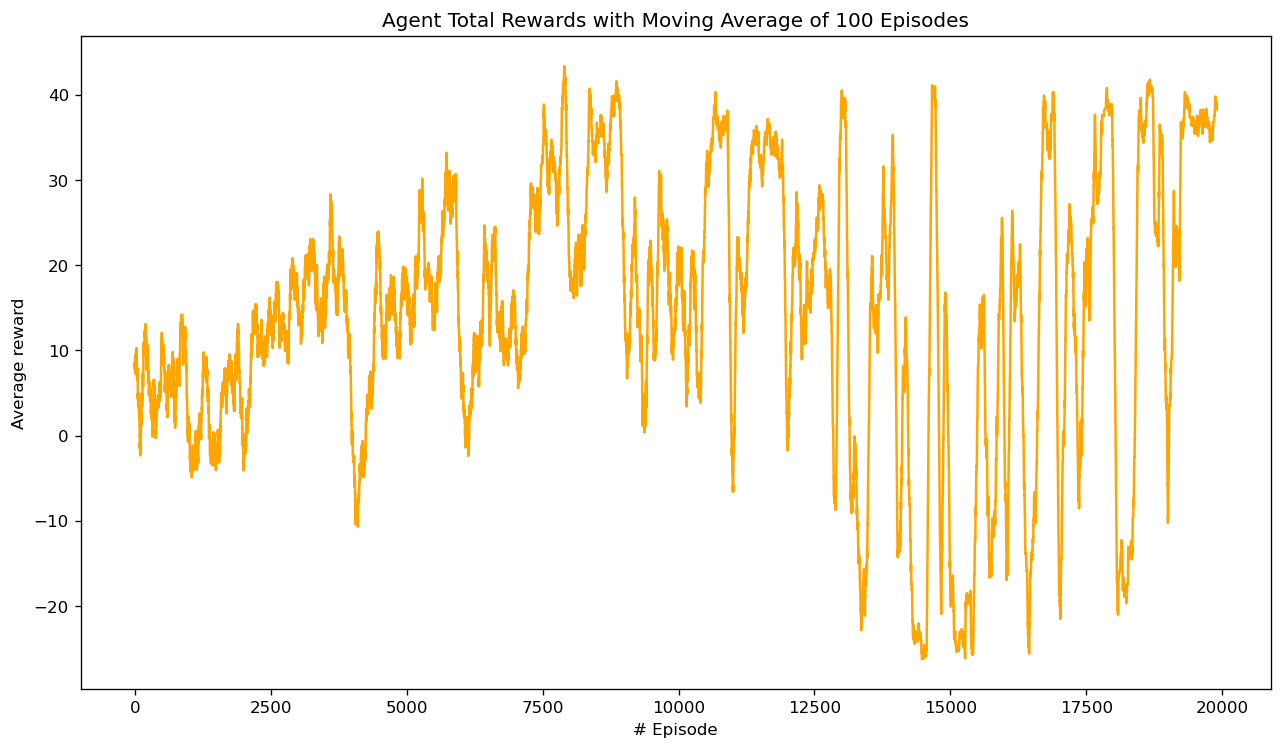

In [9]:
avg_reward_100 = np.convolve(rewards, np.ones(100), mode='valid') / 100

fig, ax = plt.subplots(dpi=120, figsize=(12.8, 7.2))
ax.plot(avg_reward_100, color='orange', linestyle='-')
ax.set_ylabel('Average reward')
ax.set_xlabel('# Episode')
ax.title.set_text('Agent Total Rewards with Moving Average of 100 Episodes')

In [10]:
def my_agent(obs, config):
    # define agent
    agent = Agent(
        config, 
        input_shape=(None, 6, 7, 2),
        testing=True,
    )
    agent.load_DQN_weights('./models/best-param-self-play.h5')

    # preprocessing of the state
    state = preprocess_board_state(obs)

    return agent.choose_action(state)

def mean_reward(rewards, pos):
    return sum(r[pos] for r in rewards) / float(len(rewards))


score_rand_0 = mean_reward(evaluate("connectx", [my_agent, random_agent], num_episodes=50), 0)
score_rand_1 = mean_reward(evaluate("connectx", [random_agent, my_agent], num_episodes=50), 1)

print('My agent vs. random: {} random vs. My agent: {}'.format(score_rand_0, score_rand_1))

score_nega_0 = mean_reward(evaluate("connectx", [my_agent, negamax_agent], num_episodes=50), 0)
score_nega_1 = mean_reward(evaluate("connectx", [negamax_agent, my_agent], num_episodes=50), 1)

print('My agent vs. negamax: {} negamax vs. My agent: {}'.format(score_nega_0, score_nega_1))

score_nstep_0 = mean_reward(evaluate("connectx", [my_agent, nstep_lookahead_agent], num_episodes=50), 0)
score_nstep_1 = mean_reward(evaluate("connectx", [nstep_lookahead_agent, my_agent], num_episodes=50), 1)

print('My agent vs. n-step lookahead: {} n-step lookahead vs. My agent: {}'.format(score_nstep_0, score_nstep_1))

My agent vs. negamax: 0.68 negamax vs. My agent: 0.68
My agent vs. negamax: -1.0 negamax vs. My agent: -0.96
My agent vs. negamax: -1.0 negamax vs. My agent: -1.0
